# MIRELLA – Notebook 2: Computational analysis to simulate RNase reallocation.

In [1]:
import os
import numpy as np
from scipy.integrate import solve_ivp

imgs_path = os.path.join(os.path.dirname(os.path.dirname(os.path.realpath("__file__"))), 'docs')

cmap = ['#898B8C', '#A4D7B0', '#79C9C1', '#4DB0CF', '#2B8BBD', '#08579D']

class mRNA_Degrad_Simulator():
    """mRNA Degradation Simulator."""
    
    def __init__(self, t_max=None, params=None, init_cond=None):
        """Constructor."""
        # Simulation time.
        self.t_max= t_max 
        # Set the model parameters.
        self.set_model_parameters(params)
        # Set the initial condition.
        self.set_initial_condition(init_cond)
    
    def set_model_parameters(self, params):
        self.params = dict(params)
    
    def set_aux_params(self):
        self.aux_params = {
            'beta_t' : ((self.params['beta_t_deg'] + self.params['mu']) / 
                        self.params['beta_t_plus']), 
            'beta_t_q' : ((self.params['beta_t_q_deg'] + self.params['mu']) / 
                          self.params['beta_t_q_plus']), 
            'beta_c' : ((self.params['beta_c_deg'] + self.params['mu']) / 
                        self.params['beta_c_plus'])
        }
    
    def set_initial_condition(self, init_cond):
        self.init_cond = dict(init_cond)
    
    def set_x0(self):
        self.x0 = np.array([
            self.init_cond['mt'], 
            self.init_cond['mtq'], 
            self.init_cond['q'], 
            self.init_cond['mc'], 
            self.init_cond['dt'],
            self.init_cond['dtq'],
            self.init_cond['dc']
        ])
    
    def simulate_model(self):
        """Simulate the ODE model"""
        self.set_aux_params()
        self.set_x0()
        
        # Simulate the ODE model using the Radau method
        tspan = (0, self.t_max)
        soln = solve_ivp(self.ss_model, tspan, self.x0, method='Radau', rtol=1e-6, atol=1e-9)
        
        # Retrieve the solution from soln
        self.t, self.x = soln.t, soln.y
        self.mt, self.mtq, self.q, self.mc, self.dt, self.dtq, self.dc = self.x
        self.g = self.aux_func_g(self.dt, self.dtq, self.dc)
    
    def ss_model(self, t, x): 
        """ODE model"""
        mt, mtq, q, mc, dt, dtq, dc = x
        g = self.aux_func_g(dt, dtq, dc)
        
        # Calculate the vector field
        dmt = (self.params['alpha_t'] - (self.params['eta_plus'] * q + 
                                      self.params['beta_t_plus'] * g + self.params['mu']) * mt)
        dmtq = (self.params['eta_plus'] * mt * q - 
                (self.params['beta_t_q_plus'] * g + self.params['mu']) * mtq)
        dq = (self.params['alpha_q'] + self.params['beta_t_q_deg'] * dtq - 
              (self.params['eta_plus'] * mt + self.params['beta_q'] + self.params['mu']) * q)
        dmc = (self.params['alpha_c'] - 
               (self.params['beta_c_plus'] * g + self.params['mu']) * mc)
        ddt = (self.params['beta_t_plus'] * g * mt - 
               (self.params['beta_t_deg'] + self.params['mu']) * dt)
        ddtq = (self.params['beta_t_q_plus'] * g * mtq - 
                (self.params['beta_t_q_deg'] + self.params['mu']) * dtq)
        ddc = (self.params['beta_c_plus'] * g * mc - 
               (self.params['beta_c_deg'] + self.params['mu']) * dc)
        # Return the vector field
        return np.array([dmt, dmtq, dq, dmc, ddt, ddtq, ddc])
    
    def aux_func_g(self, dt, dtq, dc):
        return self.params['g0'] - dt - dtq - dc

Set model parameters for model simulations.

In [2]:
parameters = {
    'alpha_t' : 1., # mKate mRNA production rate (nM /h) 
    'eta_plus' : 5., # mKate:miRNA binding rate (/h /nM) 
    'beta_t_plus' : 1., # Association constant between mKate mRNA and RNase (/nM /h)
    'beta_t_deg' : 1., #  Degradation rate of mKate:RNase complex(/h) 
    'beta_t_q_plus' : 500., # Association constant between mKate:miRNA:RNase (/nM /h) 
    'beta_t_q_deg' : 1., # Degradation rate of mKate:miRNA:RNase complex(/h) 
    'alpha_q' : 0.05, # miRNA production rate (nM /h) 
    'beta_q' : np.log(2.)/10., # Half-life miRNA (/h)
    'alpha_c' : 0.1, # Endogenous mRNA production rate (nM /h) 
    'beta_c_plus' : 10., # Association constant between endogenous mRNA:RNase (/nM /h) 
    'beta_c_deg' : 1., # Degradation rate of endogenous mRNA:miRNA:RNase complex(/h) 
    'g0' : 1., # Total RNase concentration (nM)
    'mu' : 0.029 # Growth rate (/h)
} # Model parameters

Simulate the ODE model to study how endogenous mRNA degradation depends on miRNA regulation.

In [3]:
# Helper functions

def run_sims(t_max, params, etas_plus):
    """Run simulations of endogenous mRNA degradation."""
    # Set initial condition
    init_cond = {
        'mt' : 0., # mKate mRNA initial concentration (nM)
        'mtq' : 0., # mKate:miRNA mRNA initial concentration (nM)
        'q' : 0., # miRNA initial concentration (nM)
        'mc' : 0., # Endogenous mRNA initial concentration (nM)
        'dt' : 0., # mKate mRNA:RNase complex (nM)
        'dtq' : 0., # mKate mRNA:miRNA:RNase complex (nM)
        'dc' : 0. # Endogenous mRNA:RNase complex (nM)
    } 
    
    MiRoBu = mRNA_Degrad_Simulator(t_max=1e+6, params=params, init_cond=init_cond)
    
    # Simulate the ODE model to retrieve the steady-state values
    x0_values = list()
    for i in etas_plus:
        MiRoBu.params['eta_plus'] = i
        MiRoBu.simulate_model()
        x0_values.append({
            'mt' : MiRoBu.mt[-1], 
            'mtq' : MiRoBu.mtq[-1], 
            'q' : MiRoBu.q[-1], 
            'mc' : MiRoBu.mc[-1], 
            'dt' : MiRoBu.dt[-1], 
            'dtq' : MiRoBu.dtq[-1], 
            'dc' : MiRoBu.dc[-1] 
        })
    
    MiRoBu.t_max = t_max
    MiRoBu.params['alpha_t'], MiRoBu.params['alpha_q'], MiRoBu.params['alpha_c'] = 0, 0, 0
    
    sims = list()
    for i in range(len(etas_plus)):
        MiRoBu.init_cond.update(x0_values[i])
        MiRoBu.params['eta_plus'] = etas_plus[i]
        MiRoBu.simulate_model()
        sims.append({
            't' : MiRoBu.t, 
            'mt' : MiRoBu.mt / (MiRoBu.mt[0] + np.finfo(float).eps), 
            'mtq' : MiRoBu.mtq / (MiRoBu.mtq[0] + np.finfo(float).eps), 
            'q' : MiRoBu.q / (MiRoBu.q[0] + np.finfo(float).eps), 
            'mc' : MiRoBu.mc / (MiRoBu.mc[0] + np.finfo(float).eps), 
            'dt' : MiRoBu.dt / (MiRoBu.dt[0] + np.finfo(float).eps), 
            'dtq' : MiRoBu.dtq / (MiRoBu.dtq[0] + np.finfo(float).eps), 
            'dc' : MiRoBu.dc / (MiRoBu.dc[0] + np.finfo(float).eps), 
            'g' : MiRoBu.g, 
            'abs_mt' : MiRoBu.mt, 
            'abs_mtq' : MiRoBu.mtq, 
            'abs_q' : MiRoBu.q, 
            'abs_mc' : MiRoBu.mc, 
            'abs_dt' : MiRoBu.dt, 
            'abs_dtq' : MiRoBu.dtq, 
            'abs_dc' : MiRoBu.dc 
        })
        
    return sims

## Fig. 4b

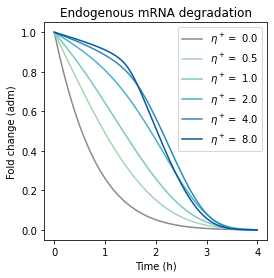

In [4]:
from turtle import color
from matplotlib import pyplot as plt

etas_plus = np.array([0, 0.5, 1, 2, 4, 8]) 

sims = run_sims(t_max=4, params=parameters, etas_plus=etas_plus)

plt.figure(figsize=[4, 4])
for i, obj in enumerate(sims):
    tmp_label = r'$\eta^+ = $' + f' {etas_plus[i]}'
    plt.plot(obj['t'], obj['mc'], label=tmp_label, color=cmap[i])
plt.legend()
plt.xlabel('Time (h)')
plt.ylabel('Fold change (adm)')
plt.title('Endogenous mRNA degradation')

plt.savefig(os.path.join(imgs_path, 'Fig4b.pdf'), format='pdf')

## Supplementary Fig. S4a

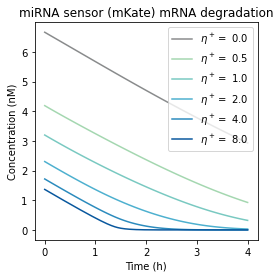

In [5]:
plt.figure(figsize=[4, 4])
for i, obj in enumerate(sims):
    tmp_label = r'$\eta^+ = $' + f' {etas_plus[i]}'
    plt.plot(obj['t'], obj['abs_mt'] + obj['abs_mtq'], label=tmp_label, color=cmap[i])
plt.legend()
plt.xlabel('Time (h)')
plt.ylabel('Concentration (nM)')
plt.title('miRNA sensor (mKate) mRNA degradation')

plt.savefig(os.path.join(imgs_path, 'FigS4a.pdf'), format='pdf')

## Supplementary Fig. S4b

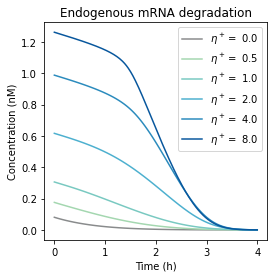

In [6]:
plt.figure(figsize=[4, 4])
for i, obj in enumerate(sims):
    tmp_label = r'$\eta^+ = $' + f' {etas_plus[i]}'
    plt.plot(obj['t'], obj['abs_mc'], label=tmp_label, color=cmap[i])
plt.legend()
plt.xlabel('Time (h)')
plt.ylabel('Concentration (nM)')
plt.title('Endogenous mRNA degradation')

plt.savefig(os.path.join(imgs_path, 'FigS4b.pdf'), format='pdf')

## Supplementary Fig. S4c

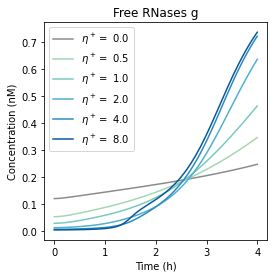

In [7]:
plt.figure(figsize=[4, 4])
for i, obj in enumerate(sims):
    tmp_label = r'$\eta^+ = $' + f' {etas_plus[i]}'
    plt.plot(obj['t'], obj['g'], label=tmp_label, color=cmap[i])
plt.legend()
plt.xlabel('Time (h)')
plt.ylabel('Concentration (nM)')
plt.title('Free RNases g')

plt.savefig(os.path.join(imgs_path, 'FigS4c.pdf'), format='pdf')

## Supplementary Fig. S4d

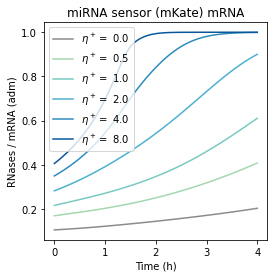

In [8]:
plt.figure(figsize=[4, 4])
for i, obj in enumerate(sims):
    tmp_label = r'$\eta^+ = $' + f' {etas_plus[i]}'
    plt.plot(obj['t'], (obj['abs_dt'] + obj['abs_dtq']) / 
             (obj['abs_dt'] + obj['abs_dtq'] + obj['abs_mt'] + obj['abs_mtq']), label=tmp_label, color=cmap[i])
plt.legend()
plt.xlabel('Time (h)')
plt.ylabel('RNases / mRNA (adm)')
plt.title('miRNA sensor (mKate) mRNA')

plt.savefig(os.path.join(imgs_path, 'FigS4d.pdf'), format='pdf')

## Supplementary Fig. S4e

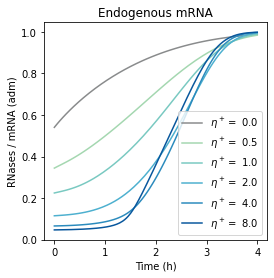

In [9]:
plt.figure(figsize=[4, 4])
for i, obj in enumerate(sims):
    tmp_label = r'$\eta^+ = $' + f' {etas_plus[i]}'
    plt.plot(obj['t'], obj['abs_dc'] / (obj['abs_dc'] + obj['abs_mc']), label=tmp_label, color=cmap[i])
plt.legend()
plt.xlabel('Time (h)')
plt.ylabel('RNases / mRNA (adm)')
plt.title('Endogenous mRNA')

plt.savefig(os.path.join(imgs_path, 'FigS4e.pdf'), format='pdf')

## Supplementary Fig. S5a

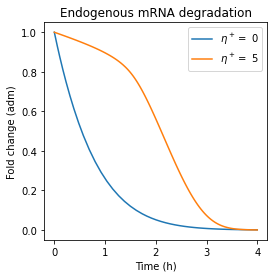

In [10]:
etas_plus = np.array([0, 5]) 

sims = run_sims(t_max=4, params=parameters, etas_plus=etas_plus)

plt.figure(figsize=[4, 4])
for i, obj in enumerate(sims):
    tmp_label = r'$\eta^+ = $' + f' {etas_plus[i]}'
    plt.plot(obj['t'], obj['mc'], label=tmp_label)
plt.legend()
plt.xlabel('Time (h)')
plt.ylabel('Fold change (adm)')
plt.title('Endogenous mRNA degradation')

plt.savefig(os.path.join(imgs_path, 'FigS5a.pdf'), format='pdf')

## Supplementary Fig. S5b

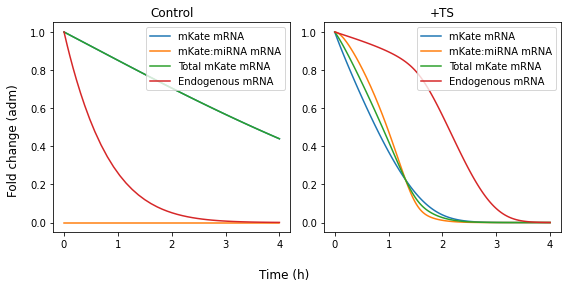

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[8, 4])
title = ['Control', '+TS']
for i, obj in enumerate(sims):
    ax[i].plot(obj['t'], obj['mt'])
    ax[i].plot(obj['t'], obj['mtq'])
    ax[i].plot(obj['t'], (obj['mt'] + obj['mtq']) / (obj['mt'][0] + obj['mtq'][0]))
    ax[i].plot(obj['t'], obj['mc'])
    ax[i].legend(['mKate mRNA', 'mKate:miRNA mRNA', 'Total mKate mRNA', 'Endogenous mRNA'])
    ax[i].set_title(title[i])
fig.supxlabel('Time (h)')
fig.supylabel('Fold change (adm)')
fig.tight_layout()

plt.savefig(os.path.join(imgs_path, 'FigS5b.pdf'), format='pdf')

## Supplementary Fig. S5c

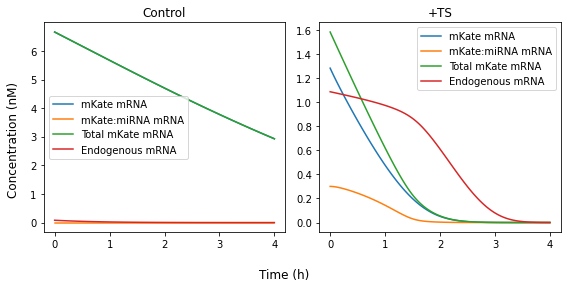

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[8, 4])
for i, obj in enumerate(sims):
    ax[i].plot(obj['t'], obj['abs_mt'])
    ax[i].plot(obj['t'], obj['abs_mtq'])
    ax[i].plot(obj['t'], (obj['abs_mt'] + obj['abs_mtq']))
    ax[i].plot(obj['t'], obj['abs_mc'])
    ax[i].legend(['mKate mRNA', 'mKate:miRNA mRNA', 'Total mKate mRNA', 'Endogenous mRNA'])
    ax[i].set_title(title[i])
fig.supxlabel('Time (h)')
fig.supylabel('Concentration (nM)')
fig.tight_layout()

plt.savefig(os.path.join(imgs_path, 'FigS5c.pdf'), format='pdf')